# `CIFAR10` Image Classification Challenge (Version 0.2) Convolutional Layer

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as tf_hub

TensorFlow 2.x selected.


In [0]:
from matplotlib import style

import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib3

In [0]:
logger = tf.get_logger()

logger.setLevel(logging.ERROR)
style.use('ggplot')
tfds.disable_progress_bar()
urllib3.disable_warnings(category=urllib3.exceptions.InsecureRequestWarning)

In [0]:
splitting = tfds.Split.ALL.subsplit(weighted=(70, 20, 10))
splitting

(NamedSplitAll()(tfds.percent[0:70]),
 NamedSplitAll()(tfds.percent[70:90]),
 NamedSplitAll()(tfds.percent[90:100]))

In [0]:
dataset, dataset_info = tfds.load(name='cifar10', split=splitting, as_supervised=True, with_info=True)

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/1.0.2. Subsequent calls will reuse this data.


In [0]:
dataset_info

tfds.core.DatasetInfo(
    name='cifar10',
    version=1.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    urls=['https://www.cs.toronto.edu/~kriz/cifar.html'],
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [0]:
train_dataset, valid_dataset, test_dataset = dataset

In [0]:
print(train_dataset)
print(valid_dataset)
print(test_dataset)

<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>


In [0]:
num_classes = dataset_info.features['label'].num_classes
class_names = np.array(dataset_info.features['label'].names)

num_training_examples = 0
for example_tr in train_dataset:
  num_training_examples += 1

num_validation_examples = 0
for example_val in valid_dataset:
  num_validation_examples += 1

num_testing_examples = 0
for example_tes in test_dataset:
  num_testing_examples += 1

print("Classes : {}\n".format(num_classes))

for i, class_name in enumerate(class_names):
  print("Class : {} --> {}".format(i, class_name))

print("\nNumber of training examples   : {}".format(num_training_examples))
print("Number of validation examples : {}".format(num_validation_examples))
print("Number of testing examples    : {}".format(num_testing_examples))

Classes : 10

Class : 0 --> airplane
Class : 1 --> automobile
Class : 2 --> bird
Class : 3 --> cat
Class : 4 --> deer
Class : 5 --> dog
Class : 6 --> frog
Class : 7 --> horse
Class : 8 --> ship
Class : 9 --> truck

Number of training examples   : 42000
Number of validation examples : 12000
Number of testing examples    : 6000


### Normalization and Dataset Preparation

In [0]:
def normalization(image, label):
  image = tf.cast(x=image, dtype=tf.float32)
  image /= 255
  return image, label

In [0]:
train_dataset = train_dataset.map(map_func=normalization)
valid_dataset = valid_dataset.map(map_func=normalization)
test_dataset = test_dataset.map(map_func=normalization)

In [0]:
train_dataset = train_dataset.cache()
valid_dataset = valid_dataset.cache()
test_dataset = test_dataset.cache()

In [0]:
BATCH_SIZE = 32
IMG_SHAPE = 32

In [0]:
training_batches = train_dataset.shuffle(buffer_size=num_training_examples//6).batch(batch_size=BATCH_SIZE).prefetch(1)
validation_batches = valid_dataset.batch(batch_size=BATCH_SIZE).prefetch(1)
testing_batches = test_dataset.batch(batch_size=BATCH_SIZE)

In [0]:
for train_img_batch, train_lab_batch in training_batches.take(1):
  break

In [0]:
print(train_img_batch.shape)
print(train_lab_batch.shape)

(32, 32, 32, 3)
(32,)


### Fabricate the Model

In [0]:
cifar10_model_v_0_2 = tf.keras.Sequential(layers=[
  tf.keras.layers.Conv2D(filters=32, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu, 
                         input_shape=(IMG_SHAPE, IMG_SHAPE, 3)), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Conv2D(filters=32, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Flatten(), 
  tf.keras.layers.Dense(units=128, activation=tf.nn.relu), 
  tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
])

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    schedule=lambda epoch: 1e-6 * 10**(epoch / 30))

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [0]:
cifar10_model_v_0_2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [0]:
cifar10_model_v_0_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          3

In [0]:
history = cifar10_model_v_0_2.fit(training_batches, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
1313/1313 [==============================] - 28s 21ms/step - loss: 2.3021 - accuracy: 0.0862
Epoch 2/100
1313/1313 [==============================] - 10s 7ms/step - loss: 2.2958 - accuracy: 0.0929
Epoch 3/100
1313/1313 [==============================] - 10s 7ms/step - loss: 2.2898 - accuracy: 0.1203
Epoch 4/100
1313/1313 [==============================] - 10s 8ms/step - loss: 2.2818 - accuracy: 0.1535
Epoch 5/100
1313/1313 [==============================] - 10s 7ms/step - loss: 2.2700 - accuracy: 0.1695
Epoch 6/100
1313/1313 [==============================] - 10s 7ms/step - loss: 2.2527 - accuracy: 0.1923
Epoch 7/100
1313/1313 [==============================] - 10s 7ms/step - loss: 2.2282 - accuracy: 0.2132
Epoch 8/100
1313/1313 [==============================] - 9s 7ms/step - loss: 2.1949 - accuracy: 0.2292
Epoch 9/100
1313/1313 [==============================] - 10s 7ms/step - loss: 2.1556 - accuracy: 0.2377
Epoch 10/100
1313/1313 [==============================] - 10s 7m

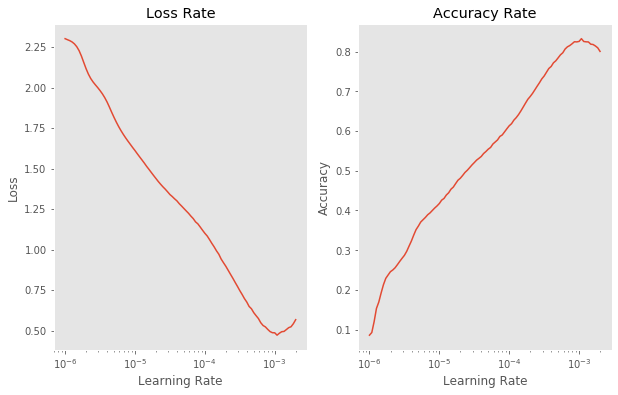

In [0]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.title("Loss Rate")
plt.semilogx(history.history['lr'], history.history['loss'])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title("Accuracy Rate")
plt.semilogx(history.history['lr'], history.history['accuracy'])
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(False)

plt.show()

Ideal `learning_rate` that reduces `loss` and increments `accuracy` metrics is `1e-3` which is $10^{-3}$.

### Recreate the Model for prediction

In [0]:
cifar10_model_v_0_2 = tf.keras.Sequential(layers=[
  tf.keras.layers.Conv2D(filters=32, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu, 
                         input_shape=(IMG_SHAPE, IMG_SHAPE, 3)), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Conv2D(filters=32, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Flatten(), 
  tf.keras.layers.Dense(units=128, activation=tf.nn.relu), 
  tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
])

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [0]:
cifar10_model_v_0_2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [0]:
cifar10_model_v_0_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 64)         

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', save_best_only=True)

In [0]:
cifar10_model_v_0_2.fit(training_batches, 
                        epochs=100, 
                        callbacks=[early_stopping, model_checkpoint], 
                        validation_data=validation_batches)

Epoch 1/100
1313/1313 [==============================] - 15s 11ms/step - loss: 1.6812 - accuracy: 0.3843 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
1313/1313 [==============================] - 10s 8ms/step - loss: 1.3573 - accuracy: 0.5172 - val_loss: 1.2398 - val_accuracy: 0.5555
Epoch 3/100
1313/1313 [==============================] - 10s 8ms/step - loss: 1.2017 - accuracy: 0.5791 - val_loss: 1.1940 - val_accuracy: 0.5726
Epoch 4/100
1313/1313 [==============================] - 10s 8ms/step - loss: 1.0906 - accuracy: 0.6198 - val_loss: 1.1005 - val_accuracy: 0.6142
Epoch 5/100
1313/1313 [==============================] - 10s 8ms/step - loss: 1.0042 - accuracy: 0.6500 - val_loss: 1.0542 - val_accuracy: 0.6320
Epoch 6/100
1313/1313 [==============================] - 11s 8ms/step - loss: 0.9353 - accuracy: 0.6744 - val_loss: 1.0035 - val_accuracy: 0.6487
Epoch 7/100
1313/1313 [==============================] - 10s 8ms/step - loss: 0.8819 - accuracy: 0.6920 - val_loss:

In [0]:
cifar10_model_v_0_2 = tf.keras.models.load_model(filepath='./best_model.h5')

In [0]:
cifar10_model_v_0_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 64)         

In [0]:
for test_img_batch, test_lab_batch in testing_batches.take(1):
  break

In [0]:
print(test_img_batch.shape)
print(test_lab_batch.shape)

(32, 32, 32, 3)
(32,)


In [0]:
prediction_batch = cifar10_model_v_0_2.predict(test_img_batch)

In [0]:
print(prediction_batch)
print(prediction_batch.shape)

[[1.89977709e-05 2.37781364e-06 4.51695814e-05 3.08463108e-02
  2.07210155e-06 9.68638420e-01 5.00629612e-05 3.92952825e-05
  3.49391688e-04 7.90190097e-06]
 [1.16132826e-01 3.96453738e-01 8.01440212e-04 1.69547759e-02
  3.84580463e-01 1.40089570e-02 3.10827582e-03 2.77228141e-03
  4.83430959e-02 1.68441478e-02]
 [3.33671421e-01 3.32807470e-03 3.61517608e-01 4.91822809e-02
  9.25097018e-02 5.18895462e-02 2.18673106e-02 6.42515207e-03
  3.68618704e-02 4.27470431e-02]
 [2.55936384e-03 4.94132582e-05 5.23886569e-02 2.96658128e-01
  1.24309957e-03 2.07831468e-02 3.25541501e-03 6.17045879e-01
  2.35688785e-05 5.99325961e-03]
 [2.96399325e-01 4.53802604e-05 2.59261392e-02 8.22873320e-04
  6.69994116e-01 3.15813319e-04 2.00694718e-04 1.86280301e-03
  4.40557860e-03 2.72760190e-05]
 [9.78938770e-03 3.72616632e-05 4.26797032e-01 1.43196225e-01
  4.93250526e-02 3.54019165e-01 2.36357865e-03 1.35582620e-02
  8.49623873e-04 6.44461397e-05]
 [8.67839158e-01 5.32867794e-04 7.19417149e-05 2.20145541e

In [0]:
for i in range(BATCH_SIZE):
  if np.argmax(prediction_batch[i]) == test_lab_batch[i]:
    print("{} --> {} : {}".format(
        True, class_names[np.argmax(prediction_batch[i])], round(np.max(prediction_batch[i])*100, 3)))
  else:
    print("{}".format(False))

True --> dog : 96.864
False
False
True --> horse : 61.705
True --> deer : 66.999
False
True --> airplane : 86.784
False
True --> automobile : 99.997
True --> dog : 57.536
True --> cat : 49.866
False
False
False
False
False
True --> horse : 99.687
True --> ship : 54.518
True --> automobile : 100.0
True --> deer : 80.723
False
True --> automobile : 99.989
True --> truck : 96.974
True --> automobile : 66.903
True --> frog : 71.94
True --> ship : 97.352
True --> deer : 90.398
True --> bird : 42.813
True --> truck : 53.084
True --> frog : 99.864
True --> deer : 83.461
False


In [0]:
def plot_the_image(index_i, predict_batch_arr, actual_labels, images_tested):
  predict_batch_arr = predict_batch_arr[index_i]
  actual_label = actual_labels[index_i]
  image_testing = images_tested[index_i]

  plt.imshow(image_testing)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  predicted_label = np.argmax(predict_batch_arr)

  if predicted_label == actual_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{}  {:.2f}% ({})".format(class_names[predicted_label], 
                                       100*np.max(predict_batch_arr), 
                                       class_names[actual_label]), color=color)

def plot_the_predicted_array(index_i, predict_batch_arr, actual_labels):
  predict_batch_arr = predict_batch_arr[index_i]
  actual_label = actual_labels[index_i]

  this_plot = plt.bar(x=range(10), height=predict_batch_arr, color='#777777')
  plt.grid(False)
  plt.xticks(range(10))
  plt.ylim([0, 1])

  this_plot[np.argmax(predict_batch_arr)].set_color('red')
  this_plot[actual_label].set_color('green')

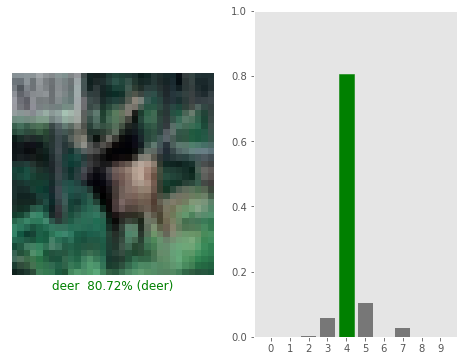

In [0]:
plt.figure(figsize=(8, 6))

index_i = 19

plt.subplot(1, 2, 1)
plot_the_image(index_i=index_i, 
               predict_batch_arr=prediction_batch, 
               actual_labels=test_lab_batch, 
               images_tested=test_img_batch)
plt.subplot(1, 2, 2)
plot_the_predicted_array(index_i=index_i, 
                         predict_batch_arr=prediction_batch, 
                         actual_labels=test_lab_batch)
plt.show()

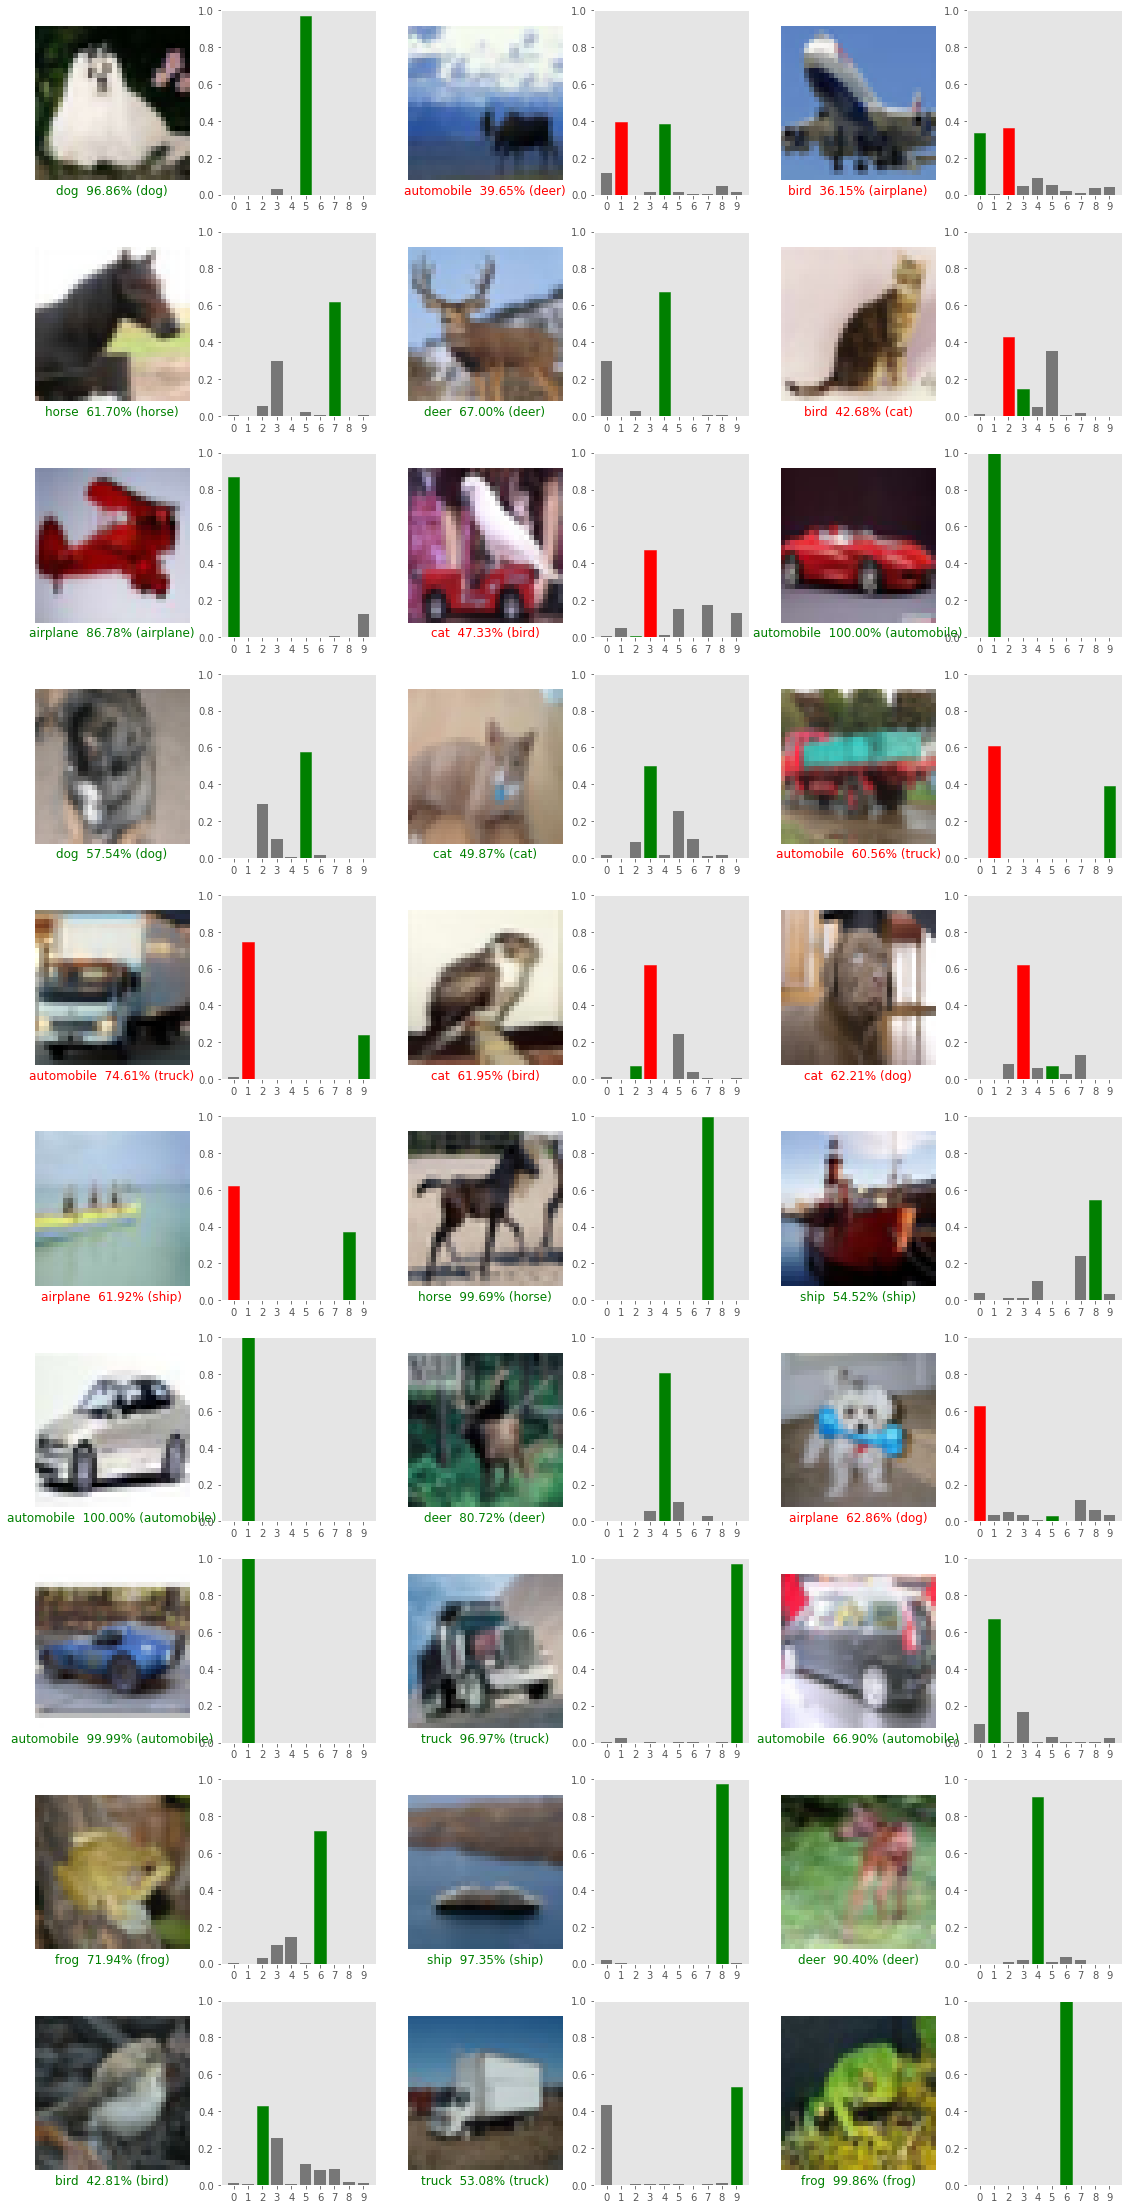

In [0]:
num_rows = 10
num_cols = 3
grid_size = num_rows * num_cols

plt.figure(figsize=((2*2+(2.5))*num_cols, (2*2)*num_rows))

for index_i in range(grid_size):
  plt.subplot(num_rows, 2*num_cols, 2*index_i+1)
  plot_the_image(index_i=index_i, 
                 predict_batch_arr=prediction_batch, 
                 actual_labels=test_lab_batch, 
                 images_tested=test_img_batch)
  plt.subplot(num_rows, 2*num_cols, 2*index_i+2)
  plot_the_predicted_array(index_i=index_i, 
                           predict_batch_arr=prediction_batch, 
                           actual_labels=test_lab_batch)
plt.show()